# Flow Matching: From Intuition to Application

This notebook introduces the basic concepts of **Flow Matching** and shows an application to the simulation of detector data from a CMS-like experiment.

Flow Matching is a powerful framework for generative modeling that learns to transform a simple distribution (like Gaussian noise) into a complex target distribution (like real data). The key idea is to learn a **vector field** that describes how to transport samples from the source to the target distribution.

### Structure

**Part 1: Building Intuition**
- Understanding vector fields and probability paths
- Visualizing conditional paths vs. marginal paths
- 2D Gaussian-to-Gaussian transformation example

**Part 2: Application to CMS Data**
- Building affine probability paths
- Training a neural network to learn the vector field
- Simulating detector-level features

### References
- [Flow Matching Blog Post](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html)
- We use **JAX** as the ML framework for this tutorial

**Time:** ~1 hour for students to go through the material

## Part 1: Understanding Flow Matching

### What do we want?

Let’s assume we have data samples from a distribution of interest $p_1$, whose density is unknown. We’re interested in using these samples to learn a probabilistic model approximating $p_1$ In particular, we want efficient generation of new samples (approximately ) distributed from $p_1$. This task is referred to as **generative modelling**.

Thus we'd like to transform one well-known distribution $p_0$ into another, potentially unknown data distribution $p_1$. ideally, there exists a **marginal probability path** $p_t$ which moves point between the two distribution according to some continuous transformation. Problem: this is a messy and difficult task, expensive to evaluate and to train on.


### So what are we trying to learn?

In Flow Matching, our goal is to learn a **time-dependent vector field** $v_t(x)$ that describes how to continuously transform samples from a simple source distribution $p_0$ (e.g., standard Gaussian) to a complex target distribution $p_1$ (e.g., real data).

Think of it like this:
- At time $t=0$: we have noise from $p_0$
- At time $t=1$: we want to have realistic samples from $p_1$
- In between: the vector field $v_t(x)$ tells us which direction to move each point

The key insight of Flow Matching is that we don't directly learn the complex **marginal** vector field. Instead, we learn simpler **conditional** vector fields $v_t(x|x_1)$ that depend on individual data points $x_1$.

So in the end the loss function will be a simple regression between the output of our NN $v_{\theta}(t,x)$ and this vector field $v_t$.

$$\mathcal{L}_{\text{CFM}}(\theta)=\mathbb{E}_{t}\!\Bigl[\,\bigl\|v_{\theta}(t,x)-v_{t}(x\mid x_{1})\bigr\|^{2}\Bigr]$$

Surprisingly, this loss function is equivalent to approximating the full *marginal* path, so that our network in the end will learn the general transformation mapping between the two distributions.

### Setup: Import Libraries

In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, vmap
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# Set random seed for reproducibility
key = random.PRNGKey(42)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.7.2
JAX devices: [CpuDevice(id=0)]


### Example: 2D Gaussian to Gaussian

Let's start with a simple example: transforming one 2D Gaussian distribution into another. This will help us visualize the concepts.

We'll define:
- **Source distribution** $p_0$: Standard Gaussian $\mathcal{N}(0, I)$
- **Target distribution** $p_1$: Gaussian $\mathcal{N}(\mu_1, \Sigma_1)$ with different mean and covariance

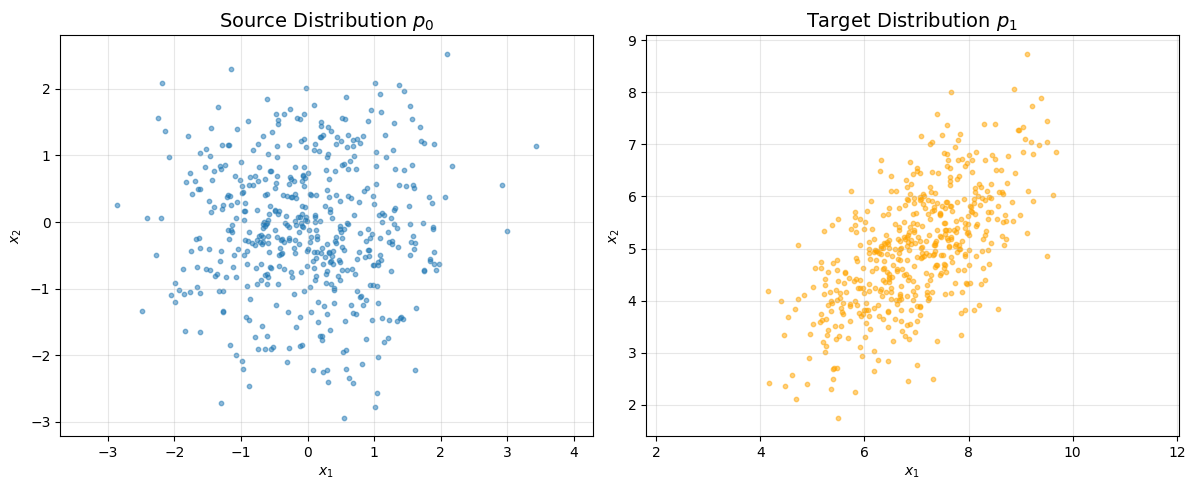

Source mean: [-0.0124717  -0.09780891]
Target mean: [6.975809 4.986193]


In [2]:
# Define source and target distributions
def sample_source(key, n_samples):
    """Sample from source distribution p_0 = N(0, I)"""
    return random.normal(key, (n_samples, 2))

def sample_target(key, n_samples):
    """Sample from target distribution p_1 = N(mu_1, Sigma_1)"""
    # Target parameters: shifted and rotated Gaussian
    mu_1 = jnp.array([7.0, 5.0])
    
    # Create a covariance matrix with correlation
    angle = jnp.pi / 4  # 45 degree rotation
    rotation = jnp.array([[jnp.cos(angle), -jnp.sin(angle)],
                          [jnp.sin(angle), jnp.cos(angle)]])
    scale = jnp.array([[2.0, 0.0], [0.0, 0.5]])
    Sigma_1 = rotation @ scale @ rotation.T
    
    # Sample from standard Gaussian and transform
    z = random.normal(key, (n_samples, 2))
    return z @ jnp.linalg.cholesky(Sigma_1).T + mu_1

# Sample from both distributions
key, subkey1, subkey2 = random.split(key, 3)
n_samples = 500
x_0_samples = sample_source(subkey1, n_samples)
x_1_samples = sample_target(subkey2, n_samples)

# Visualize the distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x_0_samples[:, 0], x_0_samples[:, 1], alpha=0.5, s=10)
ax1.set_title('Source Distribution $p_0$', fontsize=14)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

ax2.scatter(x_1_samples[:, 0], x_1_samples[:, 1], alpha=0.5, s=10, color='orange')
ax2.set_title('Target Distribution $p_1$', fontsize=14)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

print(f"Source mean: {jnp.mean(x_0_samples, axis=0)}")
print(f"Target mean: {jnp.mean(x_1_samples, axis=0)}")

### Conditional Probability Paths

The key idea in Flow Matching is to use **conditional probability paths**. Given a target data point $x_1$, we define a path from noise $x_0 \sim p_0$ to $x_1$ at time $t \in [0,1]$, named $p_t (x_t)$ and satisfying the boundary conditions:

$$p_0(\mathbf{x} \mid \mathbf{x}_1) = p_0 \quad\text{and}\quad
p_1(\mathbf{x} \mid \mathbf{x}_1) = \mathcal{N}\!\bigl(\mathbf{x};\,\mathbf{x}_1,\sigma_{\text{min}}^{2}\mathbf{I}\bigr)
\xrightarrow[\sigma_{\text{min}}\to 0]{}\delta_{\mathbf{x}_1}(\mathbf{x})$$

i.e. we shrink from the initial noisy points to our single, conditional data point. If we are transforming from gaussians to gaussians:

![boundary](./figs/heatmap_with_cond_traj-v3.png)

Such a probability path is implemented by a transformation (or *flow*):

$$x_t = \psi_t(x_0, x_1)$$

A simple choice of **affine** path is :
$$x_t = (1 - (1 - \sigma_{\text{min}}) t) x_0 + t x_1$$

This means:
- At $t=0$: $x_t = x_0$ (we start at noise)
- At $t=1$: $x_t = x_1 + \sigma_{\text{min}} x_0 \approx \delta (x_1)$ (we arrive at the data point with an arbitrary small variance from the noise)
- In between: we interpolate according to our transformation (*flow*).

The **conditional vector field** that implements this path can be [shown](https://mlg.eng.cam.ac.uk/2024/01/20/flow-matching.html#gaussian-probability-paths) to be:
$$v_t(x\mid x_1)=\frac{x_1-(1-\sigma_{\text{min}})\,x}{1-(1-\sigma_{\text{min}})\,t}
$$

This above is what we want the NN to learn: given a time $t$ and $x_t$ transformed as above, which is the $v_t(x\mid x_1)$ to move the current $x_t$ closer to the endpoint $x_1$? This is a regression task.

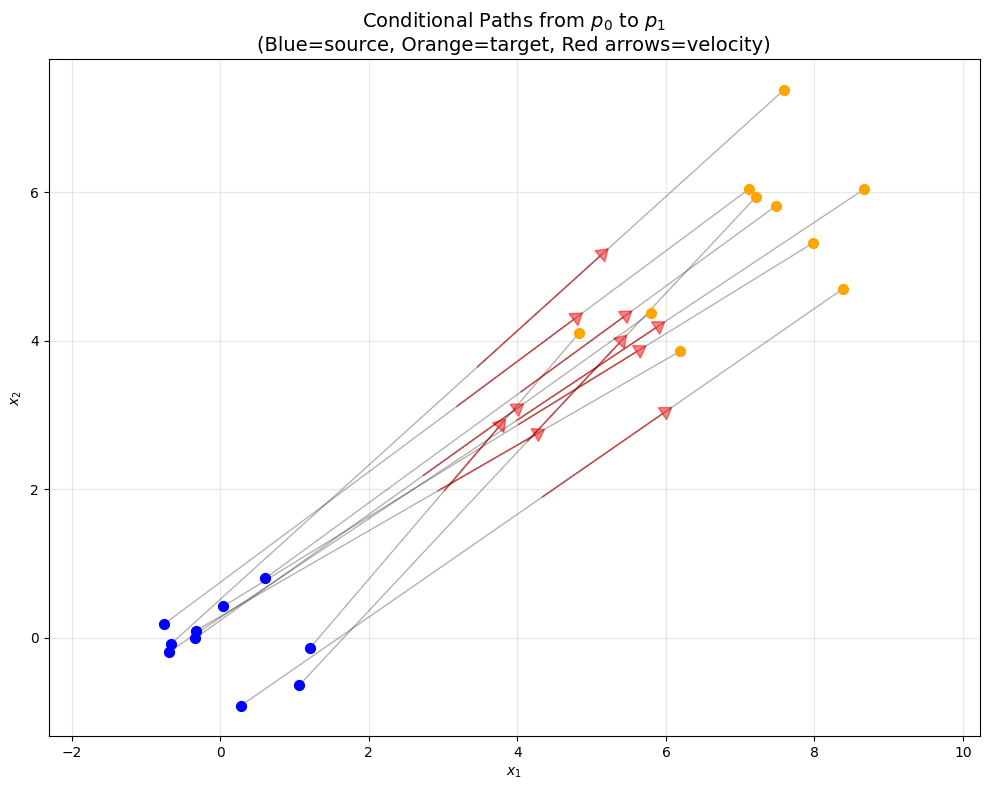

Each black line shows a conditional path from a source point (blue) to a target point (orange)
Red arrows show the velocity vector field at t=0.5
 What if we want to send all the source points to the same target point?


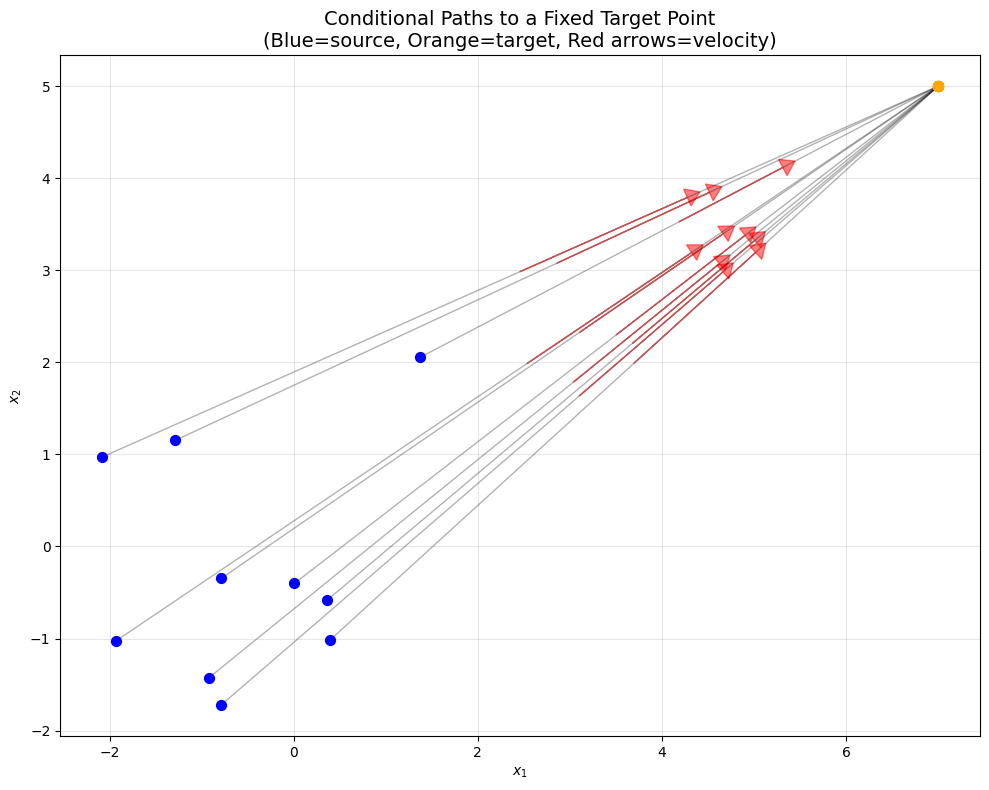

Notice how the path is conditional in the sense that given the target point it attracts or conditions the path of all source points

You can play around with the timestamp parameter in the cell above to see how the magnitude of v_t changes at different times


In [10]:
# Define the affine conditional path
def conditional_path(x_0, x_1, t, sigma_min=0.0001):
    """
    Affine conditional probability path from x_0 to x_1
    
    Args:
        x_0: Source point(s), shape (..., d)
        x_1: Target point(s), shape (..., d)
        t: Time in [0, 1], scalar or shape (...)
        sigma_min: Minimum variance parameter
    
    Returns:
        x_t: Point(s) at time t along the path
    """
    # Ensure t has the right shape for broadcasting
    t = jnp.atleast_1d(t)
    while t.ndim < x_0.ndim:
        t = t[..., None]
    
    return (1 - (1 - sigma_min) * t) * x_0 + t * x_1

def conditional_vector_field(x_0, x_1, t, sigma_min=0.0001):
    """
    Conditional vector field: the time derivative of the path
    
    
    Args:
        x_0: Source point(s)
        x_1: Target point(s)
        t: Time (not used for affine paths, but kept for consistency)
        sigma_min: Minimum variance parameter
    
    Returns:
        Velocity vector
    """
    return (x_1 - (1 - sigma_min) * x_0) / (1 - (1 - sigma_min) * t)

# Visualize a few conditional paths
fig, ax = plt.subplots(figsize=(10, 8))

# Take 10 random pairs of (x_0, x_1)
n_paths = 10
timestamp = 0.5
indices = random.choice(random.PRNGKey(0), n_samples, (n_paths,), replace=False)

# Plot paths
times = jnp.linspace(0, 1, 50)
for idx in indices:
    x_0 = x_0_samples[idx]
    x_1 = x_1_samples[idx]
    
    # Compute path
    path = vmap(lambda t: conditional_path(x_0, x_1, t))(times)
    
    # Plot path
    ax.plot(path[:, 0], path[:, 1], 'k-', alpha=0.3, linewidth=1)
    ax.scatter(x_0[0], x_0[1], c='blue', s=50, zorder=5)
    ax.scatter(x_1[0], x_1[1], c='orange', s=50, zorder=5)
    
    # Plot velocity vector at t=0.5
    x_mid = conditional_path(x_0, x_1, timestamp)
    v_mid = conditional_vector_field(x_0, x_1, timestamp)
    ax.arrow(x_mid[0], x_mid[1], v_mid[0]*0.1, v_mid[1]*0.1, 
             head_width=0.2, head_length=0.15, fc='red', ec='red', alpha=0.5)

ax.set_title('Conditional Paths from $p_0$ to $p_1$\n(Blue=source, Orange=target, Red arrows=velocity)', 
             fontsize=14)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

print("Each black line shows a conditional path from a source point (blue) to a target point (orange)")
print("Red arrows show the velocity vector field at t=0.5")
print(" What if we want to send all the source points to the same target point?")

fig, ax = plt.subplots(figsize=(10, 8))
# Take 10 random source points
n_paths = 10
indices = random.choice(random.PRNGKey(1), n_samples, (n_paths,), replace=False)
fixed_target = jnp.array([7.0, 5.0])  # Fixed target point

for idx in indices:
    x_0 = x_0_samples[idx]
    x_1 = fixed_target
    
    # Compute path
    path = vmap(lambda t: conditional_path(x_0, x_1, t))(times)
    
    # Plot path
    ax.plot(path[:, 0], path[:, 1], 'k-', alpha=0.3, linewidth=1)
    ax.scatter(x_0[0], x_0[1], c='blue', s=50, zorder=5)
    ax.scatter(x_1[0], x_1[1], c='orange', s=50, zorder=5)
    
    # Plot velocity vector at t=0.5
    x_mid = conditional_path(x_0, x_1, timestamp)
    v_mid = conditional_vector_field(x_0, x_1, timestamp)
    ax.arrow(x_mid[0], x_mid[1], v_mid[0]*0.1, v_mid[1]*0.1, 
             head_width=0.2, head_length=0.15, fc='red', ec='red', alpha=0.5)
    
ax.set_title('Conditional Paths to a Fixed Target Point\n(Blue=source, Orange=target, Red arrows=velocity)',
                fontsize=14)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

print("Notice how the path is conditional in the sense that given the target point it attracts or conditions the path of all source points\n")
print("You can play around with the timestamp parameter in the cell above to see how the magnitude of v_t changes at different times")

### Careful! Be mindful of the underlying approximations

Remember we are learning the *conditional* vector field as a proxy for the full *marginal* field implementing the transformation. This works quite well, but it's not perfect. 

One big issue is that due to the fact that during training we sample multiple times from noise, we end up teaching to the network that a nisy sample *x_t* can correspond to multiple endpoints $x_1$, resulting in entangled, non-straight paths.

Compare the marginal paths from gaussian to gaussian below:

![marginal](./figs/g2g-forward_samples.png)

to the conditional paths which we are having the network learning:

![condtional](./figs/g2g-vector-field-samples-cond.png)

You can see quite clearly that it's all tangled up, with points from one end of the starting distribution being connected to point on the other end of the final distribution. This is not always desirable.

### Summary of Part 1

**What we learned:**

1. **Flow Matching learns vector fields** that transport samples from a source distribution (noise) to a target distribution (data)

2. **Conditional paths** $x_t = (1 - (1 - \sigma_{\text{min}}) t) x_0 + t x_1$ provide a simple way to connect noise to each data point

3. **Conditional vector fields** $v_t(x\mid x_1)=\frac{x_1-(1-\sigma_{\text{min}})\,x}{1-(1-\sigma_{\text{min}})\,t}$ are easy to compute and depend on the target point

4. **Different target points** give different conditional fields, each "pulling" toward that specific target

5. **The marginal vector field** $v_t(x) = \mathbb{E}_{x_1}[v_t(x|x_1)]$ is what we actually want ro learn for generation, but it's learned implicitly through the conditional fields

**Key insight:** Flow Matching is clever because we never need to compute the hard marginal field directly. Instead, we:
- Sample pairs $(x_0, x_1)$ from source and target
- Compute simple conditional velocities $v_t(x_t|x_1)$
- Train a neural network to match these velocities
- The network automatically learns to approximate the marginal field!

---

Now let's see how to apply this to real data!

## Introduction: The Compact Muon Solenoid (CMS) experiment

The CMS experiment is a key research project at the Large Hadron Collider (LHC). It's a particle physics detector that observes and measures the byproducts of high-energy particle collisions in the LHC. CMS is designed to investigate a wide range of physics phenomena, and it played a pivotal role in the discovery of the Higgs boson in 2012.

CMS is a general-purpose detector, meaning it's equipped to study various aspects of particle physics. Its main components include a superconducting solenoid magnet, various particle detectors, and systems for tracking, energy measurement, and muon detection. This sophisticated setup allows scientists to explore several key questions in fundamental physics, such as the properties of the Higgs boson, the search for supersymmetry, the nature of dark matter, and potential evidence of extra dimensions.

<!-- insert cms image below -->
![A detailed picture of the CMS detector](./figs/cms_detect.png)


### Measuring jets at CMS

In CMS, particle jets are crucial for understanding high-energy processes. They are sprays of particles formed when quarks and gluons, produced in high-energy collisions like those at the LHC, hadronize or turn into ordinary matter. By analyzing the jets' energy and momentum, physicists can infer properties of the original particles, helping in studies like proton structure, the strong force, and new physics beyond the Standard Model.

![How a jet is generated and reconstructed](./figs/jet_structure.png)


## Hands-on generative models with CMS-like data

In High Energy Physics (HEP), simulations are crucial for understanding the outcomes of particle collisions, like those observed in the CMS experiment.
Each collision can produce a multitude of particles, making the simulation of even a single event a resource-intensive task.

Machine Learning (ML) can significantly speed up this process, particularly the reconstruction phase. By training models to emulate the behavior of particles in the detector and their interaction, we can bypass the need for detailed, step-by-step simulation, reducing computation time and resource usage.

In this second part, we aim to simulate **reconstruction-level** (reco-level) jets from **generator-level** (gen-level) data, i.e. what we reconstructed from the detector readout (reco) given what append at collision point (physics generator). For this purpose, we have prepared a dataset about 2M pairs of gen jets and their associated reco jets as produced by a CMS-like simulation script.


<div class="alert alert-block alert-success" style="background-color:lightgreen; color:green;">

<b>Problem statement:</b> Learn to simulate the features of reco-jets given the values of the associated gen-jet features.
</div>


In [11]:
import numpy as np
import matplotlib.pyplot as plt



In [13]:
!curl -o data.npy https://cernbox.cern.ch/remote.php/dav/public-files/YzEDEoU01hJNI2G/gen_ttbar_400k_final.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
